## TimeSeries & ML for Regression

### By OPTIMUM
***

두 가지 방식을 활용하여 작성하였습니다. 혹시라도 궁금하신 점이 있으시면 언제든 말씀해주세요!

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

from itertools import product, combinations
from tqdm import tqdm
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.api import seasonal_decompose

from sklearn.metrics import mean_squared_error

from statsmodels.stats.stattools import durbin_watson

In [2]:
d2019 = pd.read_excel('농가DB_2019.xlsx', header = 1)
d2020 = pd.read_excel('농가DB_2020.xlsx', header = 1)

In [41]:
d2019.head(2)

,Unnamed: 0,년도,주차,줄기길이,Unnamed: 4,Unnamed: 5,마디간격,Unnamed: 7,Unnamed: 8,잎길이,...,Unnamed: 38,과장,Unnamed: 40,Unnamed: 41,과폭,Unnamed: 43,Unnamed: 44,잎수,Unnamed: 46,Unnamed: 47
0,NaN,NaN,NaN,최적,최소,최대,최적,최소,최대,최적,...,최대,최적,최소,최대,최적,최소,최대,최적,최소,최대
1,a,2019.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
d2020.head(2)

,Unnamed: 0,년도,주차,줄기길이,Unnamed: 4,Unnamed: 5,마디간격,Unnamed: 7,Unnamed: 8,잎길이,...,Unnamed: 38,과장,Unnamed: 40,Unnamed: 41,과폭,Unnamed: 43,Unnamed: 44,잎수,Unnamed: 46,Unnamed: 47
0,NaN,NaN,NaN,최적,최소,최대,최적,최소,최대,최적,...,최대,최적,최소,최대,최적,최소,최대,최적,최소,최대
1,a,2020.0,1.0,20,20,20,6.25,6.5,6,13,...,0,0,0,0,0,0,0,5.5,5.5,5.5


In [3]:
data = pd.concat([d2019.iloc[1:, :], d2020.iloc[1:, :]], axis = 0, ignore_index = True)

2019년 데이터와 2020년 데이터를 합쳐줍니다.

In [4]:
data = data[d2019.columns[d2019.columns.str[:2] != 'Un']]

사용할 column은 각 요소별 최적값입니다.

In [9]:
data.head()

,년도,주차,줄기길이,마디간격,잎길이,잎폭,줄기굵기,화방수,화방높이,착과수,착과군,수확수,수확군,수확과중,과장,과폭,잎수
0,2019.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019.0,5.0,51.75,6,30,23.25,1,0.75,0,0,0,0,0,0,0,0,7.5
4,2019.0,6.0,59,7.3,40,33,1.1,3,0,0,0,0,0,0,0,0,11.5


In [5]:
data = data.astype(float)

데이터의 타입을 실수형으로 바꿔줍니다.

In [6]:
y = data['수확수']

우리가 예측할 값인 수확수를 target column으로 지정합니다.

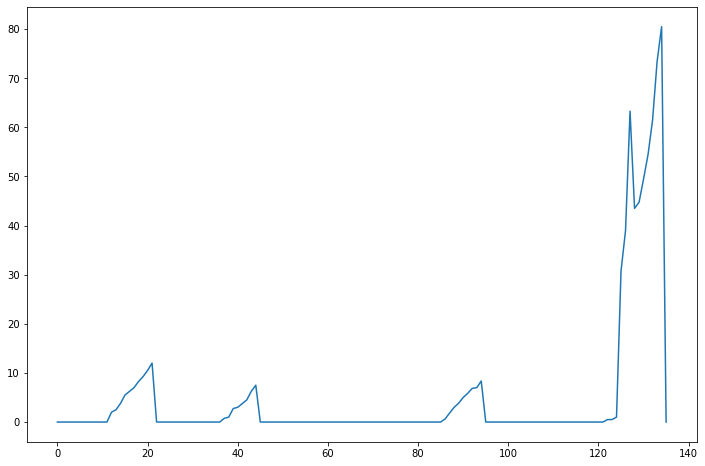

In [21]:
data['수확수'].plot()
plt.show()

분석에 앞서 주기성을 살펴보기 위해 plotting을 한 결과 특별한 주기성은 보이지 않습니다.

In [13]:
y = data['수확수']
y1dif = data['수확수'].diff(periods = 1).dropna()

result = adfuller(y)
print("원 데이터의 ADF 값 : {}".format(result[0]))
print('원 데이터의 P-value : {}\n'.format(result[1]))

result1 = adfuller(y1dif, autolag = None)
print("1차 차분 데이터의 ADF 값 : {}".format(result1[0]))
print('1차 차분 데이터의 P-value : {}'.format(result1[1]))

원 데이터의 ADF 값 : -2.114181611957707
원 데이터의 P-value : 0.23885047286046657

1차 차분 데이터의 ADF 값 : -3.4716389876291815
1차 차분 데이터의 P-value : 0.008746048444982571


1차 차분을 진행하면 정상성을 만족하는 것으로 나타났습니다.

### 1. TimeSeries Method

In [44]:
y_train = data['수확수'].iloc[:130]
y_test = data['수확수'].iloc[130:]

In [45]:
tr_exog = data[['줄기길이', '마디간격', '잎길이', '잎폭', '줄기굵기', '화방수', '화방높이', '착과수', '착과군', '수확군', '수확과중', '과장', '과폭', '잎수']].iloc[:130]
te_exog = data[['줄기길이', '마디간격', '잎길이', '잎폭', '줄기굵기', '화방수', '화방높이', '착과수', '착과군', '수확군', '수확과중', '과장', '과폭', '잎수']].iloc[130:]

데이터를 학습과 검증 데이터로 나눕니다. 

In [28]:
p, q = range(0,3), range(0,3)
d = range(0, 2)
P, Q = range(0,3), range(0,3)
D = range(0,2)
m = 0
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result = SARIMAX(y_train, trend = 'c', 
                                   order = trend_param, seasonal_order = seasonal_params, exog = tr_exog).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0], SARIMAX_order[AIC.index(min(AIC))][1]))

  6%|▌         | 1/18 [00:00<00:08,  2.02it/s]

Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 0, 0, 0) AIC=912.2734000364576, BIC=958.1539512437469


 11%|█         | 2/18 [00:00<00:06,  2.55it/s]

Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 0, 0, 0) AIC=854.9104151263069, BIC=903.6585007840519


 22%|██▏       | 4/18 [00:01<00:04,  3.41it/s]

Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 0, 0, 0) AIC=756.1467110060089, BIC=807.7623311142094
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 0, 0) AIC=736.8525107356523, BIC=782.609509205439


 28%|██▊       | 5/18 [00:01<00:03,  4.11it/s]

Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 0, 0) AIC=738.8353531795573, BIC=787.4521640537057


 33%|███▎      | 6/18 [00:01<00:03,  3.49it/s]

Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 0, 0) AIC=669.5074346417815, BIC=720.9840579202917


 39%|███▉      | 7/18 [00:02<00:03,  3.50it/s]

Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 0, 0, 0) AIC=746.9386179067423, BIC=795.6867035644872


 44%|████▍     | 8/18 [00:02<00:03,  3.31it/s]

Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 0, 0, 0) AIC=752.631580234422, BIC=804.2472003426225


 50%|█████     | 9/18 [00:02<00:02,  3.06it/s]

Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 0, 0, 0) AIC=702.1522524323661, BIC=756.6354069910223


 56%|█████▌    | 10/18 [00:03<00:02,  3.10it/s]

Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 0, 0) AIC=738.8199768510525, BIC=787.4367877252009


 61%|██████    | 11/18 [00:03<00:02,  2.96it/s]

Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 0, 0) AIC=739.388167487077, BIC=790.864790765587


 67%|██████▋   | 12/18 [00:03<00:02,  2.82it/s]

Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 0, 0) AIC=659.2586938253123, BIC=713.5951295081841


 72%|███████▏  | 13/18 [00:04<00:01,  2.78it/s]

Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 0, 0, 0) AIC=748.7771881924631, BIC=800.3928083006635


 78%|███████▊  | 14/18 [00:04<00:01,  2.72it/s]

Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 0, 0, 0) AIC=746.9777141071529, BIC=801.460868665809


 83%|████████▎ | 15/18 [00:05<00:01,  2.66it/s]

Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 0, 0, 0) AIC=718.6574500386653, BIC=776.0081390477769


 89%|████████▉ | 16/18 [00:05<00:00,  2.69it/s]

Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 0, 0) AIC=721.5753466652864, BIC=773.0519699437964


 94%|█████████▍| 17/18 [00:05<00:00,  2.70it/s]

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 0, 0) AIC=708.3602239603733, BIC=762.6966596432451


100%|██████████| 18/18 [00:06<00:00,  2.87it/s]

Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 0, 0) AIC=660.4315077407834, BIC=717.6277558280169
The smallest AIC is 659.2586938253123 for model SARIMAX(1, 1, 2)x(0, 0, 0, 0)


조합을 이용해 AIC가 최소가 되는 파라미터 조합을 탐색합니다.

In [29]:
print(f'ARMA 파라미터는 {SARIMAX_order[AIC.index(min(AIC))][0]}')
print(f'계절성 주기는 {SARIMAX_order[AIC.index(min(AIC))][1]}')

ARMA 파라미터는 (1, 1, 2)
계절성 주기는 (0, 0, 0, 0)


SARIMAX의 파라미터인 ARMA파라미터와 계절성 파라미터를 확인합니다.

In [30]:
model = SARIMAX(y_train, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order=SARIMAX_order[AIC.index(min(AIC))][1], exog = tr_exog).fit()
display(model.summary())

pred = model.get_forecast(len(y_test), exog=te_exog).predicted_mean

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    수확수   No. Observations:                  130
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -310.629
Date:                Wed, 04 Aug 2021   AIC                            659.259
Time:                        08:23:26   BIC                            713.595
Sample:                             0   HQIC                           681.337
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3717      1.434      0.259      0.796      -2.439       3.183
줄기길이          -0.0347      0.027     -1.286      0.199      -0.087       0.018
마디간격           0.0066      0.159      0.041      0.967      -0.306       0.319
잎길이            0.2003      0.157      1.278      0.201      -0.107       0.507
잎폭            -0.1783      0.172     -1.035      0.301      -0.516       0.159
줄기굵기           0.3442      6.266      0.055      0.956     -11.936      12.625
화방수            0.9544      1.286      0.742      0.458      -1.565       3.474
화방높이        2.508e-16        nan        nan        nan         nan         nan
착과수            0.7691      0.705      1.091      0.275      -0.613       2.151
착과군                 0   9.39e-15          0      1.000   -1.84e-14    1.84e-14
수확군                 0        nan        nan        nan         nan         nan
수확과중                0        nan        nan        nan         nan         nan
과장                  0         -0        nan        nan           0           0
과폭                  0         -0        nan        nan           0           0
잎수            -0.0021      0.283     -0.007      0.994      -0.557       0.553
ar.L1         -0.2670      0.517     -0.516      0.606      -1.281       0.747
ma.L1          0.5464      0.168      3.250      0.001       0.217       0.876
ma.L2          0.9525      0.206      4.630      0.000       0.549       1.356
sigma2         7.2320      1.276      5.666      0.000       4.730       9.734
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19356.68
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              11.46   Skew:                             5.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.99e+37. Standard errors may be unstable.
"""

앞서 획득한 파라미터 조합을 활용해 모델을 만든 후 데이터를 학습한 후 검증 데이터를 활용해 예측합니다.

In [33]:
print(f'SARIMA 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

SARIMA 모형의 RMSE = 29.706970418207906


예측 데이터와 실제 값을 비교하니 RMSE가 약 30이 나온 것을 알 수 있습니다.

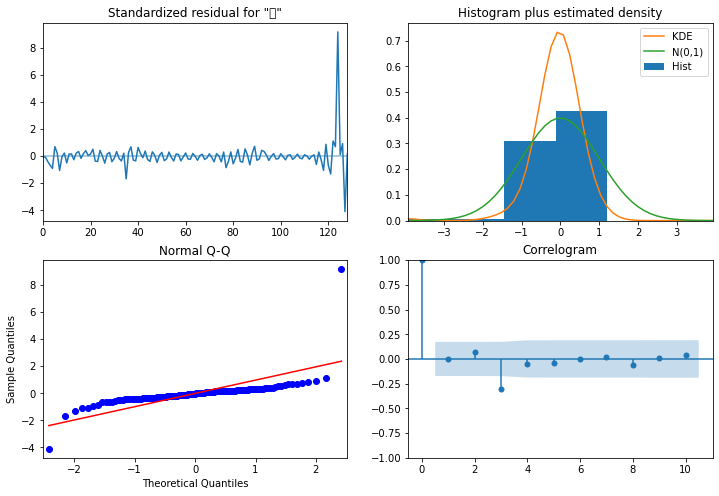

In [37]:
plt.rcParams['figure.figsize'] = (12, 8)
model.plot_diagnostics()
plt.show()

모델의 진단 플롯을 그려 적절히 모델링이 수행됐는지 확인합니다.

In [40]:
durbin_watson(model.resid)

2.0076658238873013

더빈 왓슨 통계량이 2인 것으로 보아 오차가 자기상관성은 띄지 않는 것으로 확인됩니다.

***

### 2. ML Method

In [43]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

#### MinMaxScaling 적용

In [46]:
scaler = MinMaxScaler()

In [47]:
tr_scaled = scaler.fit_transform(tr_exog)

In [48]:
te_scaled = scaler.transform(te_exog)

### 2-1. scaling 전
#### RandomForestRegressor

In [49]:
rf = RandomForestRegressor(random_state = 42, n_estimators = 500)

In [50]:
rf.fit(tr_exog, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [51]:
pred = rf.predict(te_exog)

In [52]:
print(f'랜덤포레스트 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

랜덤포레스트 모형의 RMSE = 24.94211206554595


#### LGBMRegressor

In [24]:
lgbm = LGBMRegressor(random_state = 42)

In [25]:
lgbm.fit(tr_exog, y_train)

LGBMRegressor(random_state=42)

In [26]:
pred = lgbm.predict(te_exog)

In [28]:
print(f'LGBM 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

LGBM 모형의 RMSE = 41.961936475810276


#### LinearRegression

In [62]:
lg = LinearRegression()

In [63]:
lg.fit(tr_exog, y_train)

LinearRegression()

In [64]:
pred = lg.predict(te_exog)

In [65]:
print(f'LinearRegression 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

LinearRegression 모형의 RMSE = 49.89085871558645


#### 각 feature의 weight(= coefficient)

In [70]:
pd.DataFrame({'feature' : tr_exog.columns, 'coef' : lg.coef_})

,feature,coef
0,줄기길이,-2.837430e-02
1,마디간격,7.189387e-02
2,잎길이,1.462764e+00
3,잎폭,-1.824815e+00
4,줄기굵기,3.092876e+00
5,화방수,-4.362290e+00
6,화방높이,-1.554312e-15
7,착과수,6.063510e+00
8,착과군,0.000000e+00
9,수확군,0.000000e+00



### 2-2. Scaling 후

#### RandomForestRegressor

In [53]:
rf = RandomForestRegressor(random_state = 42, n_estimators = 500)

In [54]:
rf.fit(tr_scaled, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [55]:
pred = rf.predict(te_scaled)

In [56]:
print(f'랜덤포레스트 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

랜덤포레스트 모형의 RMSE = 24.94211206554595


#### LGBMRegressor

In [58]:
lgbm = LGBMRegressor(random_state = 42)

In [59]:
lgbm.fit(tr_scaled, y_train)

LGBMRegressor(random_state=42)

In [60]:
pred = lgbm.predict(te_scaled)

In [61]:
print(f'LGBM 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

LGBM 모형의 RMSE = 41.961936475810276


#### LinearRegression

In [71]:
lg = LinearRegression()

In [72]:
lg.fit(tr_scaled, y_train)

LinearRegression()

In [73]:
pred = lg.predict(te_scaled)

In [74]:
print(f'LinearRegression 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

LinearRegression 모형의 RMSE = 49.89085871558642


#### 각 feature의 weight(= coefficient)

In [75]:
pd.DataFrame({'feature' : tr_exog.columns, 'coef' : lg.coef_})

,feature,coef
0,줄기길이,-8.246990e+00
1,마디간격,1.150302e+00
2,잎길이,6.545870e+01
3,잎폭,-7.299262e+01
4,줄기굵기,4.484670e+00
5,화방수,-5.234748e+01
6,화방높이,-1.847411e-13
7,착과수,7.276212e+01
8,착과군,0.000000e+00
9,수확군,0.000000e+00
